# Agent-Based Modelling tutorial block

Notebook created by [Alejandra Ramirez](https://github.com/MA-Ramirez)

## Agent-based modelling

Simulation where autonomous agents react to their environment and interact with each other given a predefined set of rules. 

These rules are formulated based on explicit statements rather than mathematical equations (such as: “If condition X is fulfilled, do action Y, and then perform operation Z on all nearby agents”).
                                    *Datseris & Parlitz. (2022)*

**Advantages**
* It captures emergent phenomena from agent interactions
* Provides a natural/intuitive description of the system
* Flexible, very easy to change the rules of the simulation

## [Agents.jl](https://juliadynamics.github.io/Agents.jl/stable/)
Julia framework for agent-based modelling.

Simple to learn and use, yet extendable, focusing on fast and scalable model creation and evolution.

It allows you to focus on the composition of the ABM and not on the implementation details.

To set up an ABM simulation in Agents.jl, a user only needs to follow these steps:

1. **Choose** the kind of **space** that the agents will live in.

2. **Define** the **agent type** (or types, for mixed models) of the ABM.

3. **Define** the **model** within an Agents.jl simulation by using its universal structure `AgentBasedModel`.

4. Provide the **time evolution functions** of the ABM.

5. **Visualise** the model and animate its time evolution.

6. **Collect data**.


In this tutorial block we will model the predator-prey dynamics typically described by the Lokta-Volterra equations.

## Predator-prey dynamics

It describes the dynamics of biological systems in which two species interact, one as a predator and the other as a prey. 

### Lokta-Volterra equations
The Lokta-Volterra equations are used to model the dynamics through a pair of first-order nonlinear differential equations.

$$\frac{dx}{dt} = \alpha x - \beta xy$$
$$\frac{dy}{dt} = \delta xy - \gamma y $$

* x is the amount of prey (rabbits) 🐇
* y is the amount of predator (foxes) 🦊
* $dx/dt$ and $dy/dt$ are the instantaneous growth rates of the populations
* $\alpha$, $\beta$, $\gamma$ and $\delta$ are positive real parameters that describe the interaction between species

#### Prey dynamics 🐇
* The prey exhibits an exponential growth without being subject to predation $\alpha x$. 🐇🐇
* The rate of predation is proportional to the rate at which the predators and prey meet $- \beta xy$. 🐇🦊☠️

🐇 The rate of change of the prey's population is proportional to its size, minus the rate at which it is preyed upon. 

#### Predator dynamics 🦊
* The growth of the population is proportional to the predation of the prey $\delta xy$. 🦊🐇🍽
* There is an exponential decay in the abscence of prey. The loss rate of the predators can be due to natural death or emigration $- \gamma y $. 🦊☠️

🦊 The rate of change of the predator's population depends on the rate at which it consumes the prey, minus its intrinsic death rate.

**We will simulate the population dynamics of two species (predator 🦊 and prey 🐇) who live in a common ecosystem and compete over limited resources 🌱.**
*As implemented in the [examples of Agents.jl](https://juliadynamics.github.io/Agents.jl/stable/examples/predator_prey/)*

### Definition of the predator-prey model

* The environment is a 2D grid.
* It contains Foxes 🦊 (agent type), Rabbits 🐇 (agent type) and Grass 🌱 (spatial property).
* Foxes 🦊 **---** eat **--->** Rabbits 🐇 **---** eat **--->** Grass 🌱

The population will oscillate over time if the correct balance is achieved. If there is no balance, a population may become extinct.

* The **Grass** 🌱 is the **spatial property**. It is a replenishing resource that occupies every position in the grid space.
    - `fully_grown`: the grass can only be consumed if it is fully-grown. It is represented by a `boolean`.
    - `regrowth_time`: once the grass has been consumed, it replenishes after a given amount of time.
    - `countdown`: tracks the delay between being consumed and the regrowth time. (Eaten (regrowth_time) 5,4,3,2,1 Fully grown)

* **Foxes** 🦊 and **Rabbits** 🐇 are **agent types** that have identical properties, but different behaviours.
    - `energy`: represents an animal current energy level. If the energy drops below 0, the agent will die.
    - `delta_energy`: controls how much energy is acquired after consuming a food source.
    - `reproduction_prob`: reproduction probability. In this model individuals reproduce asexually *(assumption)*.
    
### Set up of the ABM simulation
0. Load the packages that we will be using

In [1]:
using PkgVersion, Agents, Random

PkgVersion.Version(Agents)

v"5.7.0"

1. **Choose** the kind of **space** that the agents will live in.

* The environment is a 2D grid.

`Agents.GridSpace` represents a grid with dimensionality `dims`. The keyword argument `periodic` denotes if the grid is periodic on its ends (if the an agent goes through the boundary it will re-appear in the opposite side of the grid with the same properties).

Agents live in a 2D grid with a Chebyshev metric (there are 8 neighbours around each grid point - typical grid setting).

In [2]:
dims = (20, 20)
space = GridSpace(dims, periodic = true)

GridSpace with size (20, 20), metric=chebyshev, periodic=true

* The **Grass** 🌱 is the **spatial property**. It is a replenishing resource that occupies every position in the grid space.
    - `fully_grown`: the grass can only be consumed if it is fully-grown. It is represented by a `boolean`.
    - `regrowth_time`: once the grass has been consumed, it replenishes after a given amount of time. (This is a static parameter).
    - `countdown`: tracks the delay between being consumed and the regrowth time.

In [3]:
# The properties of the Grass will be added as additional model level properties.
#`properties` contains the grass as 2 arrays: whether it is fully grown and the countdown to regrow.
# It also has regrowth_time as a static parameter.

regrowth_time = 30

properties = (
    fully_grown = falses(dims),
    regrowth_time = regrowth_time,
    countdown = zeros(Int, dims),
)

(fully_grown = Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], regrowth_time = 30, countdown = [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

2. **Define** the **agent type** (or types, for mixed models) of the ABM. 🦊🐇

* **Foxes** 🦊 and **Rabbits** 🐇 are **agent types** that have identical properties, but different behaviours.
    - `energy`: represents an animal current energy level. If the energy drops below 0, the agent will die.
    - `delta_energy`: controls how much energy is acquired after consuming a food source.
    - `reproduction_prob`: reproduction probability. In this model individuals reproduce asexually *(assumption)*.

An agent type is a standard Julia `mutable struct`. It can be created manually, but typically you'd want to use `@agent`. The types must contain some mandatory fields, which is ensured by using `@agent`. The remaining fields of the agent type are up to the user's choice.

The mandatory fields are `id::Int` (which assings a unique identification to each agent) and `pos` (it informs about the position of the agent in the space). You should never directly manipulate the mandatory fields.

We want for our agents to live in a 2D grid, so we will use the minimal agent struct `GridAgent{D}` - It has an additional `pos::NTuple{D,Int}` (tuple type that contains D elements of type Int).-

In [4]:
@agent Fox GridAgent{2} begin
    energy::Float64
    delta_energy::Float64
    reproduction_prob::Float64
end

@agent Rabbit GridAgent{2} begin
    energy::Float64
    delta_energy::Float64
    reproduction_prob::Float64
end

3. **Define** the **model** within an Agents.jl simulation by using its universal structure `AgentBasedModel`.

`AgentBasedModel(AgentType [, space]; properties, kwargs...) → model`

It creates an agent-based model for the given agent type(s) and space.

The agents are stored in a dictionary that maps unique ids (integers) to agents. Use `model[id]` to get the agent with the given `id`.

`properties`: additional model-level properties that can be accesed as `model.properties`.

`scheduler`: it decides the activation order of the agents.

`rng`: it stores the random number generation. It is used in all calls to random functions of the model.

*Note on random number generation:*

Most pseudo-random number generators (PRNGs) are built on algorithms involving some recursive method starting from a base value determined by an input called the "seed". 

The default PRNG in most statistical software is the Mersenne Twister algorithm.
In this particular algorithm, there is a recurrence relation where the input seed establishes the initial set of vectors.
The series of pseudo-random numbers generated by the algorithm is fixed by setting a seed. To set seeds in the generation of random numbers makes our code reproducible.

In [5]:
seed = 23182
rng = MersenneTwister(seed)

model = AgentBasedModel(Union{Rabbit,Fox}, space; properties, rng, scheduler = Schedulers.randomly, warn = false)

StandardABM with 0 agents of type Union{Fox, Rabbit}
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: randomly
 properties: fully_grown, regrowth_time, countdown

We now have to populate the model with agents. We define a function that will initialize the model and populate it.

To add agents to the model we will use `add_agent!(agent [, pos], model, args...)`. It creates and adds a new agent to the model using the constructor of the agent type of the model. This function takes care of setting the agent's `id` and `position`. The extra `args` are propagated to other fields of the agent constructor. If the position of the agent is not given, the agent is added to a random position.

In [6]:
function initialize_model(; 
    #KEYWORD ARGUMENTS
    n_rabbits = 100,
    n_foxes = 50,
    #space
    dims = (20,20),
    regrowth_time = 30,
    #agents
    delta_energy_rabbit = 4,
    delta_energy_fox = 20,
    prob_rabbit_reproduce = 0.04,
    prob_fox_reproduce = 0.05,
    #prng
    seed = 23182,
    )
    
    rng = MersenneTwister(seed)
    
    #space
    space = GridSpace(dims, periodic = true)
    properties = (
        fully_grown = falses(dims),
        regrowth_time = regrowth_time,
        countdown = zeros(Int, dims),
    )
    
    #model 
    model = ABM(Union{Rabbit,Fox}, space; 
        properties, rng, scheduler = Schedulers.randomly, warn = false
    )
    
    #Add agents to the model
    for _ in 1:n_rabbits
        energy = rand(model.rng, 1:(delta_energy_rabbit*2)) - 1
        add_agent!(Rabbit, model, energy, delta_energy_rabbit, prob_rabbit_reproduce)
    end   
    for _ in 1:n_foxes
        energy = rand(model.rng, 1:(delta_energy_fox*2)) - 1
        add_agent!(Fox, model, energy, delta_energy_fox, prob_fox_reproduce)
    end
    
    #Add grass to the 2D grid with a random initial growth value
    #positions(model) runs an iterator over all positions of a model with a discrete space.
    for p in positions(model)
        # define
        fully_grown = rand(model.rng, Bool)
        countdown = fully_grown ? regrowth_time : rand(model.rng, 1:regrowth_time) - 1
        
        #set
        # slurping (...) is used to pass the position as if they were multiple positions
        model.fully_grown[p...] = fully_grown
        model.countdown[p...] = countdown     
    end
    return model
end

foxrabbitgrass = initialize_model()

StandardABM with 150 agents of type Union{Fox, Rabbit}
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: randomly
 properties: fully_grown, regrowth_time, countdown

4. Provide the **time evolution functions** of the ABM.

We will now define the behaviour/interactions of 🐇, 🦊 and 🌱.

**Behaviour of the 🐇 and 🦊**.
The behaviour of both agent types is similar.
* Both move to a random adjacent position with the `walk!` function.
* Both lose 1 energy unit by moving to an adjacent position.
* Both consume a food source if available.
* If the energy level of an agent is below zero, it dies. Otherwise, it lives and reproduces with some probability.

In Agents.jl, an agent-based model should be accompanied with at least one (and at most two) stepping functions.

An *agent step function* is required by default. It defines what happens to an agent when it is activated.
- It must accept two arguments: 1. an agent instance 2. a model instance
- Our `agent_step!` function is called `rabbitfox_step!` and it is dispatched to the appropriate agent type via Julia's Multiple Dispatch system.

A *model step function* can be also needed sometimes. It changes all agents at once, or changes a model property.
- It must accept one argument: 1. the model


*Note*

We will use the following predefined Agents.jl functions:
* `walk!(agent, rand, model)`: moves the agents in the grid. The function invokes a random walk by providing the `rand` function, when refering to the direction in which the agent moves. `ifempty` will check that the target position is unoccupied and only move if that's true. (Foxes can move into a position where there is a rabbit, in order to eat it.)
* `kill_agent!(agent, model)`: removes an agent from the model.

In [7]:
function rabbitfox_step!(rabbit::Rabbit, model)
    #Both move to a random adjacent position with the walk! function
    walk!(rabbit, rand, model)
    #Both lose 1 energy unit by moving to an adjacent position
    rabbit.energy -= 1
    
    #If the energy level of an agent is below zero, it dies
    if rabbit.energy < 0
        kill_agent!(rabbit, model)
        return
    end
    #Both consume a food source if available.
    eat!(rabbit, model)
    
    #Otherwise, it lives and reproduces with some probability.
    if rand(model.rng) <= rabbit.reproduction_prob
        reproduce!(rabbit, model)
    end  
end

function rabbitfox_step!(fox::Fox, model)
    #move
    walk!(fox, rand, model; ifempty=false)
    fox.energy -= 1
    
    #die
    if fox.energy < 0
        kill_agent!(fox, model)
        return
    end
    
    #eat
    #If there is any rabbit on the same grid position, it is dinner time!
    dinner = first_rabbit_in_position(fox.pos, model)
    if !isnothing(dinner)
        eat!(fox, dinner, model)
    end
    
    #reproduce
    if rand(model.rng) <= fox.reproduction_prob
        reproduce!(fox, model)
    end    
end

rabbitfox_step! (generic function with 2 methods)

In [8]:
#If there is any rabbit on the same grid position, it is dinner time!
function first_rabbit_in_position(pos, model)
    #return the ids of agents in the position corresponding to position
    ids = ids_in_position(pos, model)
    #finds the first agent type Rabbit in the list of agents that are in the position 
    j = findfirst(id -> model[id] isa Rabbit, ids)
    
    #if there is no Rabbit in the position, it returns nothing
    if isnothing(j)
        return nothing
    #if there is a Rabbit in the position, it returns that agent (type Rabbit)
    else
        return model[ids[j]]::Rabbit
    end
end

first_rabbit_in_position (generic function with 1 method)

We will now define the `eat!` functions. Rabbits and foxes have separate `eat!`functions.

Foxes 🦊 **---** eat **--->** Rabbits 🐇 **---** eat **--->** Grass 🌱

* If a fox 🦊 eats a rabbit 🐇, the rabbit dies and the fox acquires additional energy.
* If a rabbit 🐇 eats grass 🌱, the rabbit will acquire additional energy and the grass will not be available for consumption until regrowth time has elapsed.

In [9]:
function eat!(fox::Fox, rabbit::Rabbit, model)
    kill_agent!(rabbit, model)
    fox.energy += fox.delta_energy
    return
end

function eat!(rabbit::Rabbit, model)
    if model.fully_grown[rabbit.pos...]
        rabbit.energy += rabbit.delta_energy
        model.fully_grown[rabbit.pos...] = false
    end
    return
end

eat! (generic function with 2 methods)

We will now define the `reproduce!` function. Rabbits and foxes share the same `reproduce!` function.

* Reproduction has a cost of $\frac{1}{2}$ the current energy level of the parent. 
* The offspring is an exact copy of the parent, with exception of `id`.

*Predefined Agent.jl functions that we will use:*
* `nextid(model)`: return a valid `id` to create a new agent with it.
* `add_agent_pos!(agent, model)`: add the agent to the `model` at the agent's own position.

*To create the offpsring we will take advantage of generic programming*
* Generic programming allows the code to apply to as many situations as possible without requiring any changes to the original code itself.
* Parameterized types: whenever we annotate an argument as a type that is not defined yet or does not exist, we have the capability of using a parameter to determine that type. `{parameter}`
* `where` is used to denote what type, or sub-type is passed through the function. This allows us to create a dispatch, to direct the function based on what sort of type is passed.

In [10]:
function reproduce!(agent::A, model) where {A}
    agent.energy /= 2
    
    id = nextid(model)
    offspring = A(id, agent.pos, agent.energy, agent.reproduction_prob, agent.delta_energy)
    add_agent_pos!(offspring, model)
    
    return
end

reproduce! (generic function with 1 method)

**Behaviour of the 🌱**
* If it is fully grown, it is consumable. Otherwise, it cannot be consumed until it regrows after a delay specified by `regrowth_time`.
* *Note*: the countdown goes from regrowth_time to 0, when it is 0 it is fully_grown (and the countdown is reset again for when it is eaten).
* The dynamics of the grass is our `model_step!` function.

*Julia uses bounds checking to ensure program safety when accessing arrays. You may wish to skip these bounds checks to improve runtime performance in some cases. `@inbounds` macro tells the compiler to skip such bounds checks within the given block.*

In [11]:
function grass_step!(model)
    @inbounds for p in positions(model)
        
        if !(model.fully_grown[p...])
            if model.countdown[p...] <= 0
                model.fully_grown[p...] = true
                model.countdown[p...] = model.regrowth_time
            else
                model.countdown[p...] -=1
            end
        end
        
    end
end

grass_step! (generic function with 1 method)

5. **Visualise** the model and animate its time evolution.

Once we have defined a model and the stepping functions, we can visualise the model statically or animate its time evolution.

**Static plotting of ABMs**

We will use the `abmplot` function. It is an easy-to-use function, in principle one simple needs to define the functions for how the agents should be plotted.

First, we will load the required packages:

In [12]:
using InteractiveDynamics, CairoMakie

`abmplot(model::ABM; kwargs...) → fig, ax, abmobs`

It plots an agent-based model by plotting each individual agent as a marker and using the agent's position field as its location on the plot. The same function is used to make interactive applications for the model evolution using the returned `abmobs`.

* `ac, as, am`: these three keywords decide the **color**, **size**, and **marker**, that each agent will be plotted as. They can each be either a constant or a function, which takes as an input a single agent and outputs the corresponding value.

In [13]:
"""Function to define color
If the agent is type Rabbit it is white, if it is type Fox it is orange.
"""
acolor(a) = a isa Rabbit ? RGBAf(1.0, 1.0, 1.0, 0.8) : RGBAf(1.0, 0.76, 0.3, 0.8)

# The size is a constant
as = 25

"""Function to define marker
If the agent is type Rabbit it is a circle, if it is type Fox it is a triangle.
"""
amarker(a) = a isa Rabbit ? :circle : :utriangle

amarker

* `offset = nothing`: if not `nothing`, it must be a function taking as an input an agent and outputting an offset position tuple to be added to the agent's position (which matters only if there is overlap).

In [14]:
offset(a) = a isa Rabbit ? (-0.1, -0.1*rand()) : (+0.1, +0.1*rand())

offset (generic function with 1 method)

We will plot the grass as a heatmap. The growth of the grass will define its color, therefore it will be normalised with respect to `regrowth_time`.

* `heatarray = nothing`: it plots a heatmap over the space. Its values can be standard data accessors given to functions like `run!` i.e. a function of the model. The returned data must be a matrix of the same size as the underlying space. The heatmap will be updated automatically during the model evolution in videos and interactive applications.
* `heatkwargs = NamedTuple()`: keywords given to `Makie.heatmap` function if `heatarray` is not nothing.

In [15]:
grasscolor(model) = model.countdown ./ model.regrowth_time
heatkwargs = (colormap = [:brown, :green], colorrange = (0,1))

(colormap = [:brown, :green], colorrange = (0, 1))

We will now put everything together

In [16]:
plotkwargs = (;
    ac = acolor,
    as = 25,
    am = amarker,
    offset,
    #additional keyword arguments propagated to the scatter! call.
    scatterkwargs = (strokewidth = 1.0, strokecolor = :black),
    heatarray = grasscolor,
    heatkwargs = heatkwargs,
)

(ac = acolor, as = 25, am = amarker, offset = offset, scatterkwargs = (strokewidth = 1.0, strokecolor = :black), heatarray = grasscolor, heatkwargs = (colormap = [:brown, :green], colorrange = (0, 1)))

Let's plot it!

In [17]:
foxrabbitgrass = initialize_model()

StandardABM with 150 agents of type Union{Fox, Rabbit}
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: randomly
 properties: fully_grown, regrowth_time, countdown

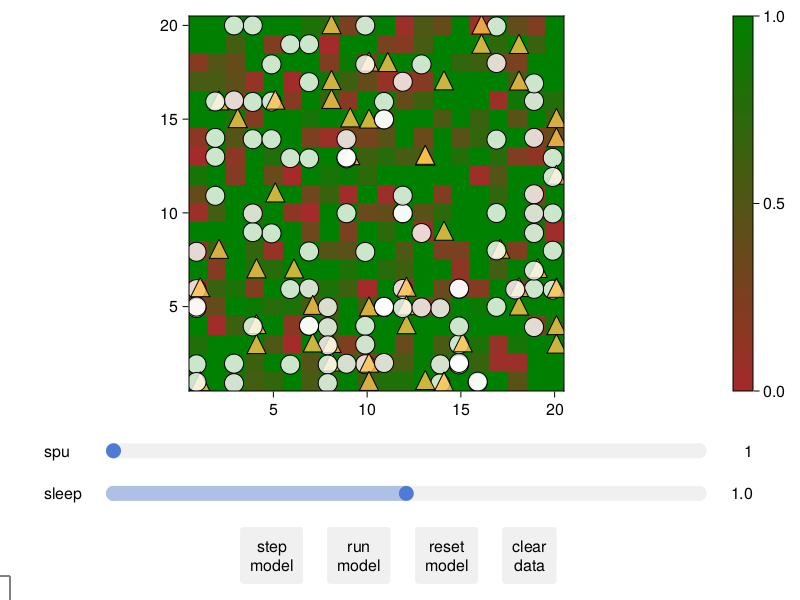

In [18]:
fig, ax, abmobs = abmplot(foxrabbitgrass;
        agent_step! = rabbitfox_step!,
        model_step! = grass_step!,
plotkwargs...)

display(fig)

We can also easily make a **video of the system's evolution**

In [19]:
abmvideo(
    "Predator_Prey_1.mp4",
    foxrabbitgrass,
    rabbitfox_step!,
    grass_step!;
    frames = 100,
    framerate = 8,
    title = "Predator-Prey Dynamics 1",
    plotkwargs...,
)

6. **Collect data**.

To collect data, we should specify the data we want to collect by providing one standard Julia `Vector`of data-to-collect for agents. Running the model and collecting data while the model runs is done with the `run!` function. The agent data names are given as the keyword `adata` and the model as keyword `mdata` to the function `run!`. This function outputs collected data in the form of a `DataFrame`.

`run!(model, agent_step!, model_step!, n::Function; kwargs...) → agent_df, model_df`
* `adata::Vector` means "agent data to collect". It specificies which properties of the agents we would like to collect as data e.g. `[:age, :height]`. If an entry is a function, e.g. `f`, then the data for this entry is `f(a)`for each agent `a`. `[:age, :height, :f]`
* `adata::Vector{<:Tuple}`: if `adata` is a vector of tuples, data aggregation is done over the agent properties. For each 2-tuple, the first entry is the "key" (any entry like the ones mentioned above, e.g. `:weight, `). The second entry is an aggregating function that aggregates the key, e.g. `mean`,`maximum`. So, continuing from the above example, we would have `adata = [(:weight, mean), (f, maximum)]`


*Additional useful functions:*
* `paramscan`: it performs data collection while scanning ranges of the parameters of the model.
* `ensemblerun!`: performs ensemble simulations and data collection.

In [20]:
# We will count the number of Rabbits, Foxes and fully-grown Grass for the time evolution of the system
rabbit(a) = a isa Rabbit
fox(a) = a isa Fox
count_grass(model) = count(model.fully_grown)

count_grass (generic function with 1 method)

In [21]:
foxrabbitgrass = initialize_model()
steps = 1000
adata = [(rabbit, count), (fox, count)]
mdata = [count_grass]
adf, mdf = run!(foxrabbitgrass, rabbitfox_step!, grass_step!, steps; adata, mdata)

(1001×3 DataFrame
  Row │ step   count_rabbit  count_fox 
      │ Int64  Int64         Int64     
──────┼────────────────────────────────
    1 │     0           100         50
    2 │     1            83         52
    3 │     2            75         54
    4 │     3            67         56
    5 │     4            59         66
    6 │     5            50         80
    7 │     6            35         88
    8 │     7            30         91
    9 │     8            27         94
   10 │     9            26         97
   11 │    10            21         96
  ⋮   │   ⋮         ⋮            ⋮
  992 │   991            23          0
  993 │   992            25          0
  994 │   993            20          0
  995 │   994            23          0
  996 │   995            29          0
  997 │   996            35          0
  998 │   997            34          0
  999 │   998            26          0
 1000 │   999            22          0
 1001 │  1000            23          0
        

We will now plot the evolution of the system

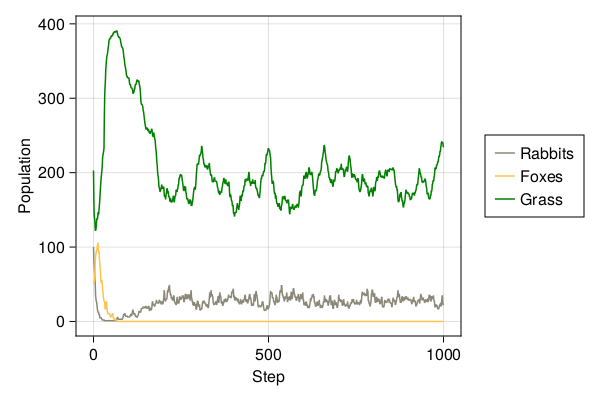

In [24]:
function plot_population_timeseries(adf, mdf)
    figure = Figure(resolution = (600, 400))
    ax = figure[1, 1] = Axis(figure; xlabel = "Step", ylabel = "Population")
    rabbitl = lines!(ax, adf.step, adf.count_rabbit, color = :cornsilk4)
    foxl = lines!(ax, adf.step, adf.count_fox, color =  RGBAf(1.0, 0.76, 0.3))
    grassl = lines!(ax, mdf.step, mdf.count_grass, color = :green)
    figure[1, 2] = Legend(figure, [rabbitl, foxl, grassl], ["Rabbits", "Foxes", "Grass"])
    figure
end

plot_population_timeseries(adf, mdf)

The plot shows the population dynamics over time. Initially, foxes become extinct because they consume the rabbits too quickly. The few remaining rabbits reproduce and gradually reach an equilibrium that can be supported by the amount of available grass.

## Exercises

For the exercises, you will be coding the agent-based simulation for different models.

To set up an ABM simulation in Agents.jl, we advice to use the following steps:

1. **Choose** the kind of **space** that the agents will live in.

2. **Define** the **agent type** (or types, for mixed models) of the ABM.

3. **Define** the **model** within an Agents.jl simulation by using its universal structure `AgentBasedModel`.

4. Provide the **time evolution functions** of the ABM.

5. **Visualise** the model and animate its time evolution.

6. **Collect data**.

*Note:* Step 5 and 6 can be interchangeable depending on the simulation's objective.

### 1. Wright-Fisher model

### Neutral model
Create an agent-based model for the neutral Wright-Fisher model. This population genetics model describes the evolution of a fixed size population that undergoes genetic drift. 

* The model will have no spatial property. Therefore, the agents are defined as `NoSpaceAgent`.
* The population is composed of `n` haploid individuals. The main property of each agent is `trait`, which will represent the fitness of the agent on a range from 0 to 1.
* The agents will be activated randomly in the model. Therefore, we need to seed the simulation to make it reproducible. In addition, we would like for our model to be initialized with the property `population_size`, in order to freely modify the amount of individuals in the population.
* At each generation, `n` offsprings replace the parents. This means that `n` offspring are sampled with replacement from the parent generation.
* The objective of the simulation is to plot the evolution of the average trait over time.

### Model with selection
Create an agent-based model for the Wright-Fisher model with selection. This means that the model now samples individuals according to their trait values (we assume that the inviduals' fitness is correlated to their trait values).

-----
*Tip: use the function `sample!`from Agents.jl*

`sample!(model::ABM, n [, weight]; kwargs...)`

It replaces the agents of the model with a random sample of the current agents with size `n`.
* `weight`: Symbol (agent field) or function (input agent out put number) to weight the sampling. This means that the higher the weight of the agent, the higher the probability that this agent will be chosen in the new sampling.